# A simple, yet complete, tutorial on how use the CCS_fit module to fit two-body interactions

In [12]:
#REMOVE SOME HARD CODING. FOR EXAMPLE: "Ne-Ne" and "Ne" which is used further down.


from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view

from ase.calculators.lj import LennardJones

LJ=bulk('Ne','fcc',a=1.55)
LJ=LJ*[2,2,2]
calc = LennardJones()
LJ.calc = calc

Fit_on_forces=True  #Enable/disable option for fitting CCS potential to atomic forces. 



### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


In [13]:
# CHECK THE RATTLE FUNCTION TO MAKE SURE THAT WE DO NOT GET THE SAME RATTLES EVERY TIME

orig_cell = LJ.get_cell()
orig_struc = LJ.copy()

displacement_magnitude=0.02  # 0.02 and disp_steps 5 leads to decieving results!
disp_steps=5
rounds=20

trainset_list="file_list" # List of strucutres to include in the data-base (see below)
f = open(trainset_list, "w")
counter=1
for round in range(rounds):
    for scale in np.linspace(0.96, 1.04, 9):
        new_cell = orig_cell*scale
        new_struc = orig_struc.copy()
        new_struc.set_cell(new_cell)
        new_struc.calc = calc
        nrg = new_struc.get_potential_energy()
        for i in range(disp_steps):
            rattle_struc = new_struc.copy()
            rattle_struc.rattle(displacement_magnitude*i)
            rattle_struc.calc = calc
            nrg = rattle_struc.get_potential_energy()
            if nrg < -40:
                counter += 1
                xyz_file=f"CALCULATED_DATA/S{counter}.xyz"
                write(xyz_file,rattle_struc)
                print(xyz_file,file=f)

f.close()
       

### BUILD REFERENCE DATA-BASE

After generating the data, we collect it in an ASE database file. The ``file_list`` is a file containing a list of files to be collected into the data base.

Example of a ``file_list`` file:

    CALCULATED_DATA/S2.xyz
    CALCULATED_DATA/S3.xyz
    CALCULATED_DATA/S4.xyz
    CALCULATED_DATA/S5.xyz
    CALCULATED_DATA/S6.xyz
    CALCULATED_DATA/S7.xyz
    CALCULATED_DATA/S8.xyz
    CALCULATED_DATA/S9.xyz



In [14]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS",DFT_DB="LJ.db",file_list="file_list",overwrite=True)

    Building data-bases: 100%|██████████| 680/680 [00:11<00:00, 56.91it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training-set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``DFT_DB`` since the most common source of reference data is DFT.

In [15]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="LJ.db",include_forces=Fit_on_forces)

    Fetching data: 100%|██████████| 680/680 [00:08<00:00, 77.42it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key.


In [20]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Ne-Ne": {
                        "Rcut": 3.0,
                        "Resolution": 0.05,
                        "Swtype": "sw",
                        "const_type" : "Mono"

                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [21]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Ne']
    Applying monotonous constraints for pair:  Ne-Ne
    Merging intervall for pair Ne-Ne. Number of knots reduced from 44 to 44. 
    Condition number is: 51018513.92845722 ( 44 1514138.7722214698 0.029678221808190096)
    MSE of unconstrained problem is:  0.08502033661659528
    Final root mean square error in energy:  0.011005754089386343  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]
    Merging intervall for pair Ne-Ne. Number of knots reduced from 44 to 44. 


    Finding optimum switch: 100%|██████████| 44/44 [00:00<00:00, 355.79it/s]

    The best switch is (7,) with MSE: 2.3878 
    Final root mean square error in energy:  0.0037616973011866455  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


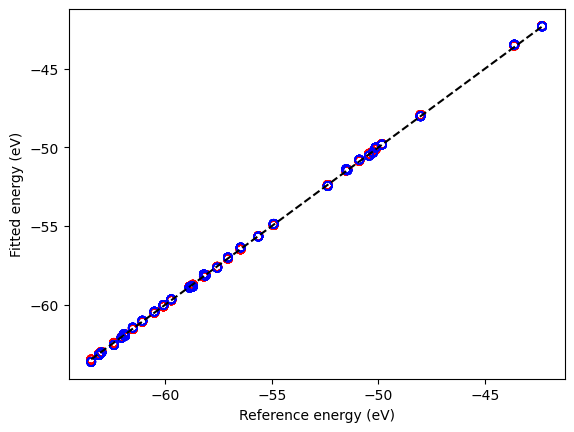

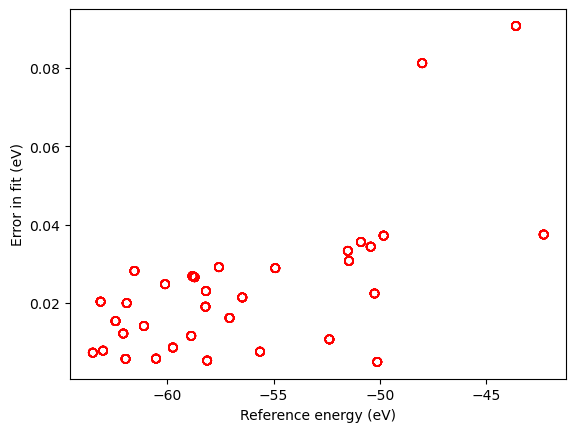

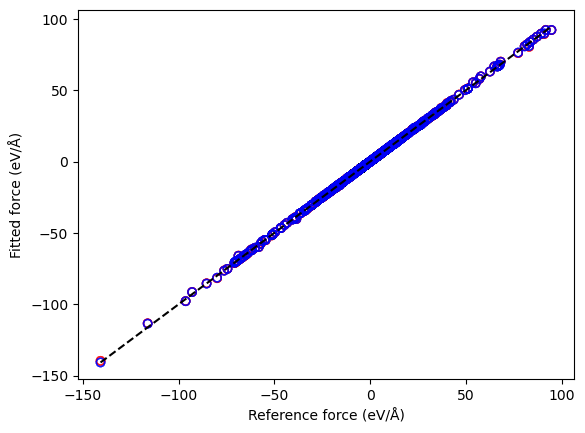

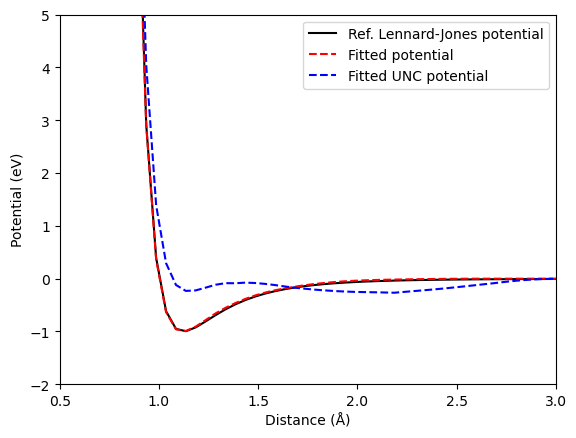

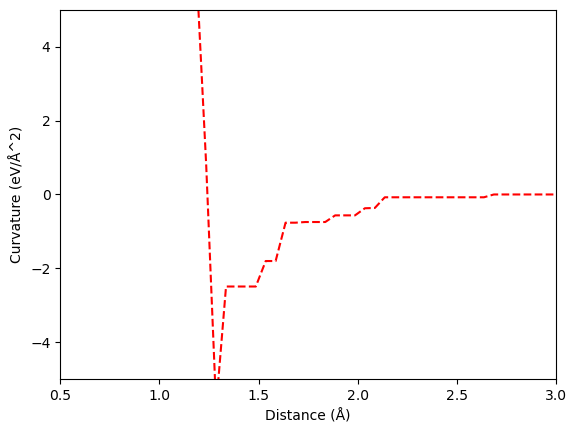

In [23]:
import matplotlib.pyplot as plt

with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

with open("structures.json", "r") as f:
    training_set = json.load(f)

with open("UNC_params.json", "r") as f:
    UNC_params = json.load(f)


r=np.array(CCS_params["Two_body"]["Ne-Ne"]["r"])
e=CCS_params["Two_body"]["Ne-Ne"]["spl_a"]
e_UNC=UNC_params["Two_body"]["Ne-Ne"]["spl_a"]
c_params=CCS_params["Two_body"]["Ne-Ne"]["spl_c"]

try:
    err=np.loadtxt("CCS_error.out")
    err_UNC=np.loadtxt("UNC_error.out")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Fitted energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.scatter(err_UNC[:,0],err_UNC[:,1],facecolors='none', edgecolors='blue')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

try:
    err_F=np.loadtxt("CCS_error_forces.out")
    err_F_UNC=np.loadtxt("UNC_error_forces.out")
    plt.xlabel('Reference force (eV/Å)')
    plt.ylabel('Fitted force (eV/Å)')
    plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
    plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
    plt.scatter(err_F_UNC[:,0],err_F_UNC[:,1],facecolors='none', edgecolors='blue',alpha=0.1 )
    plt.show()
except:
    pass

e_LJ= 4 * ((1 / r) ** 12 - (1 / r) ** 6)

plt.xlim(0.5,3)
plt.ylim(-2,5)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r,e_LJ,color='black',label="Ref. Lennard-Jones potential")
plt.plot(r,e,'--',color='red',label="Fitted potential")
plt.plot(r,e_UNC,'--',color='blue',label="Fitted UNC potential")
plt.legend()
plt.show()


plt.xlim(0.5,3)
plt.ylim(-5,5)
plt.xlabel('Distance (Å)')
plt.ylabel('Curvature (eV/Å^2)')
plt.plot(r,c_params,'--',color='red')
plt.show()

### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performin further tests on strucutres not included in the training-set is recomended but not included in the tutorial.

In [19]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS",CCS_params="CCS_params.json",DFT_DB="LJ.db")

 36%|███▋      | 248/680 [00:15<00:27, 15.77it/s]


KeyboardInterrupt: 

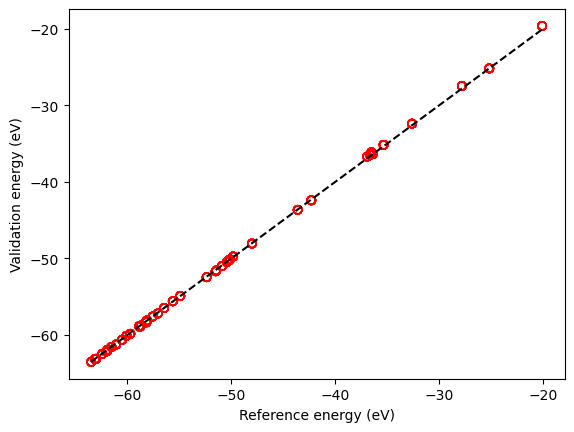

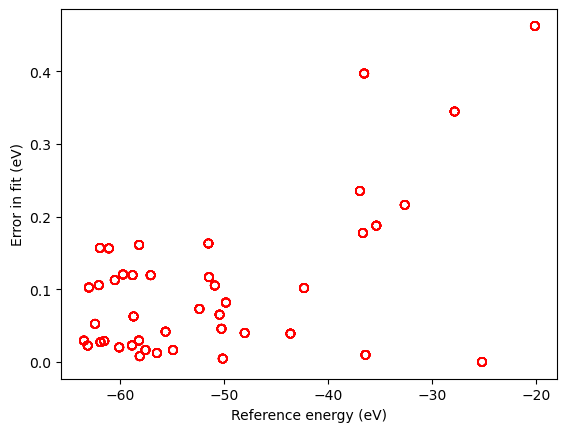

In [ ]:
try:
    err=np.loadtxt("CCS_validate.dat")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Validation energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

### Geometry optimization + Equation of state

### Phonon spectra

### Cleaning up

In [24]:
import glob
import os

def rm(file):
    try:
        os.remove(file)
    except OSError:
        pass


list=glob.glob("CALCULATED_DATA/*")
for file in list:
    rm(file)
list=glob.glob("CCS_*")
for file in list:
    rm(file)
rm("structures.json")
rm("file_list")
rm("LJ.db")